In [163]:
%%HTML
<style>
    body {
        /* Change markdown to the superior font style */
        --vscode-font-family: "Courier"
    }
</style>

In [164]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
import os

### Step 1: Data Processing

Read data from a csv file and convert that into a dataframe, which will allow for all further
analysis and data manipulation.

Package(s) required: Pandas

In [165]:
# Import the data
file_name = "Project_1_Data.csv"

# Access the data
df = pd.read_csv(f"../data/{file_name}")

# Check if there are empty values
print(f"Empty values\n{df.isnull().any()}\n")

# View df info and first few rows
print(df.info())
print(df.head())

Empty values
X       False
Y       False
Z       False
Step    False
dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       860 non-null    float64
 1   Y       860 non-null    float64
 2   Z       860 non-null    float64
 3   Step    860 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 27.0 KB
None
       X       Y     Z  Step
0  9.375  3.0625  0.50     1
1  9.375  3.0625  0.51     1
2  9.375  3.0625  0.52     1
3  9.375  3.0625  0.53     1
4  9.375  3.0625  0.54     1


### Step 2: Data Visualization

Perform statistical analysis on the dataset and visualize the dataset behaviour within each
class. This will provide an initial understanding of the raw data behaviour. You are required
to include the plots and explain the findings.

Package(s) required: Matplotlib, Pandas, Numpy

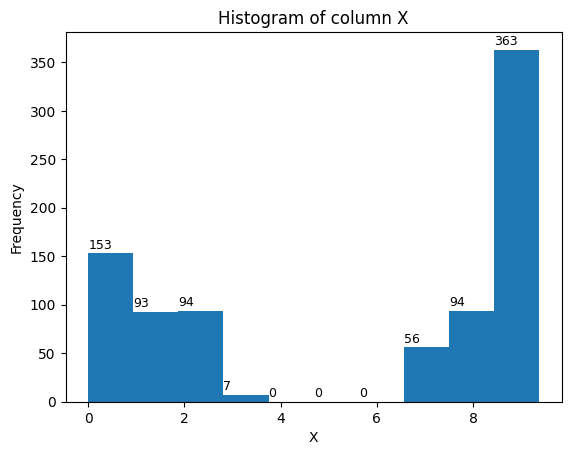

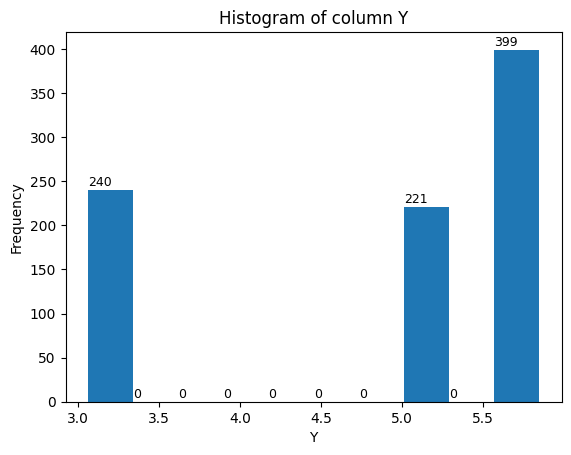

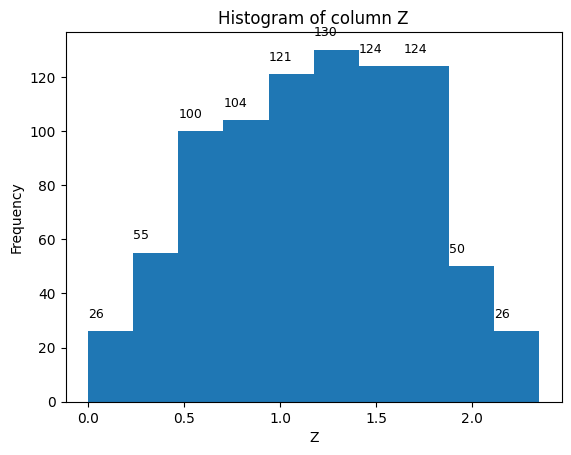

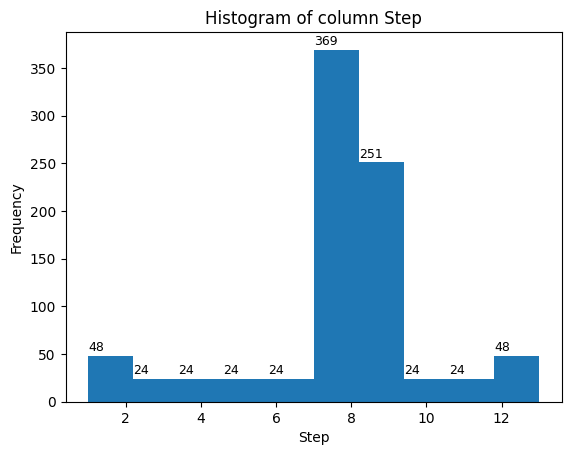

In [166]:
# Creating histograms of each column entry
for col in df.columns:
    plt.figure()  # Create a new figure each time so they don't overlap
    counts, bins, patches = plt.hist(df[col], bins=10)
    plt.title(f'Histogram of column {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Add number of occurences to each histogram bar
    for count, x in zip(counts, bins):
        plt.text(x, count + 5, str(int(count)), fontsize=9)

    plt.show()

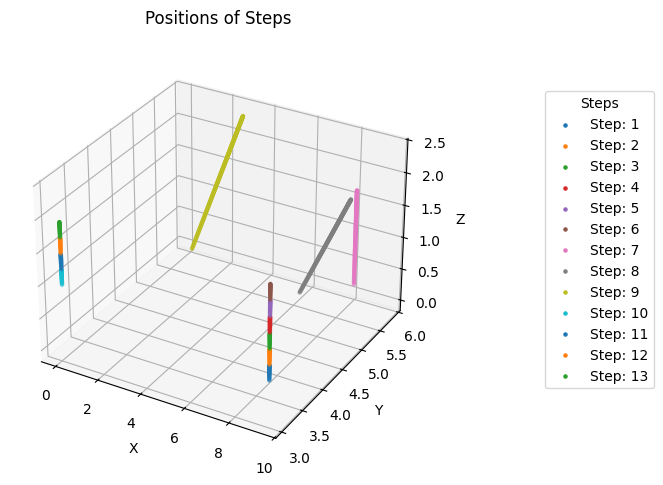

In [167]:
# Create a 3D plot of points with colour coding for each step
fig = plt.figure()
fig.suptitle("Positions of Steps")

# Create a 3d axis
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Get unique values in Step column (will be used for colour coding)
unique_vals = df["Step"].unique()

# Iterate over each unique value
for i, val in enumerate(unique_vals):
    temp_df = df[
        df["Step"] == val
    ]  # Create new df where Step is equal to current selected step
    ax.scatter(
        temp_df["X"], temp_df["Y"], temp_df["Z"], marker=".", label=f"Step: {val}"
    )

# Place legend outside of the plot
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Steps")
plt.tight_layout()
plt.show()

### Step 3: Correlation Analysis

Assess the correlation of the features with the target variable. A correlation study provides
an understanding of how the features impact the target variable. A common correlation
method used is Pearson Correlation. You are required to include the correlation plot, and
explain the correlation between the features and the target variables, along with the impact
it could have on your predictions.

Package(s) required: Seaborn, Pandas

             X         Y         Z      Step
X     1.000000  0.140759  0.013870  0.749911
Y     0.140759  1.000000  0.133676  0.292810
Z     0.013870  0.133676  1.000000  0.199531
Step  0.749911  0.292810  0.199531  1.000000


<Axes: >

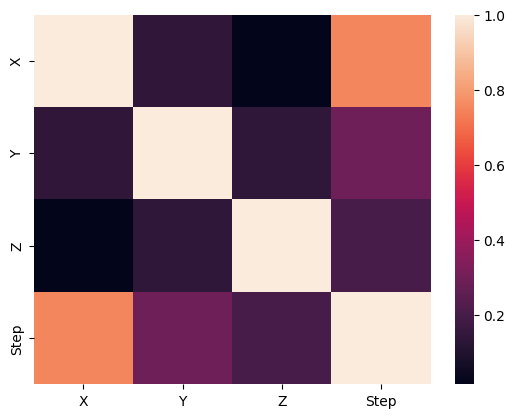

In [168]:
# Get correlation matrix
corr_matrix = df.corr()
print(abs(corr_matrix))

# Display the absolute value of the corr matrix
# Keeping "Step" incase features need to be dropped, we shall use the correlation wrt to "Step" to determine which to drop.
sns.heatmap(np.abs(corr_matrix))

Based on the correlation matrix, there appear to be no strong correlations between any of the features, thus, there is no reason to drop any of the features.

<Axes: >

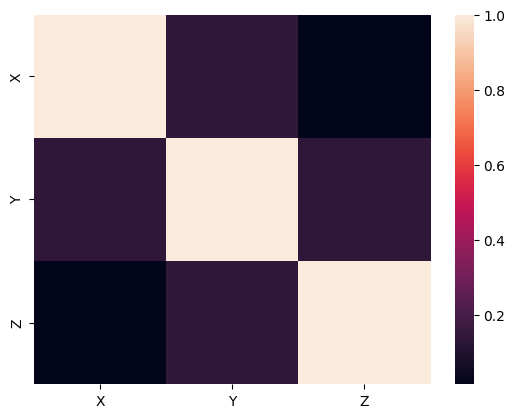

In [169]:
# Show the correlation matrix without the output variable "Step"
corr_matrix = df.drop(columns=['Step']).corr()
sns.heatmap(np.abs(corr_matrix))

### Step 4: Classification Model Development/Engineering

Prepare the data to create three classification models (based on ML algorithms). The dataset
needs to be split into training and testing categories to develop the models. For each ML
model, utilize grid search cross-validation to assess the hyperparameters that give you the
best results. You are required to explain your selected choice of classification algorithms.
In addition to the three classification models with grid search cross-validation, you must
make one model based on using RandomizedSearchCV. This will provide another method of
determining the best hyperparameters to optimize your results.

Package(s) required: scikit-learn - All ML models can be accessed from the sklearn package

In [170]:
my_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into train and test using "Step" for stratification
for train_index, test_index in my_splitter.split(df, df["Step"]):
    strat_df_train = df.loc[train_index].reset_index(drop=True)
    strat_df_test = df.loc[test_index].reset_index(drop=True)

# Training data
X_train = strat_df_train.drop(columns=["Step"])
y_train = strat_df_train["Step"]

# Testing data
X_test = strat_df_test.drop(columns=["Step"])
y_test = strat_df_test["Step"]

if X_train.isnull().any().any() or y_train.isnull().any():
    print("Warning: Training data contains NaN values. Please handle them before proceeding.")

if X_test.isnull().any().any() or y_test.isnull().any():
    print("Warning: Testing data contains NaN values. Please handle them before proceeding.")

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [171]:
# Support Vector Classifier (SVC)
svc = SVC(random_state=42)
param_grid_svc = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2, 3, 4],
    "gamma": ["scale", "auto"],
}

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring="f1_micro", n_jobs=-1)
grid_search_svc.fit(X_train, y_train)
svc_model = grid_search_svc.best_estimator_
print(f"Best SVC Model: {svc_model}")

Best SVC Model: SVC(C=1, degree=2, gamma='auto', kernel='poly', random_state=42)


In [172]:
# Logistic Regression Classifier
lrc = LogisticRegression(random_state=42)
param_grid_lrc = {
    "C": [0.1, 1, 10, 100],
    "max_iter": [200]
}
grid_search_lrc = GridSearchCV(lrc, param_grid_lrc, cv=5, scoring="neg_log_loss", n_jobs=-1)
grid_search_lrc.fit(X_train, y_train)
lrc_model = grid_search_lrc.best_estimator_
print(f"Best LRC Model: {lrc_model}")

Best LRC Model: LogisticRegression(C=100, max_iter=200, random_state=42)


In [173]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
param_grid_rfc = {
    "n_estimators": [10, 20, 50],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring="f1_micro", n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
rfc_model = grid_search_rfc.best_estimator_
print(f"Best RFC Model: {rfc_model}")

Best RFC Model: RandomForestClassifier(n_estimators=10, random_state=42)


In [174]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
param_grid_dtc = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5, scoring="f1_micro", n_jobs=-1)
grid_search_dtc.fit(X_train, y_train)
dtc_model = grid_search_dtc.best_estimator_
print(f"Best DTC Model: {dtc_model}")

Best DTC Model: DecisionTreeClassifier(random_state=42)


In [175]:
# K Neighbors Classifier - Randomized Search CV
knc_rand = KNeighborsClassifier()
param_grid_knc_rand = {
    "n_neighbors": np.arange(1, 100),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": np.arange(1, 100),
}
random_search_knc_rand = RandomizedSearchCV(
    knc_rand,
    param_grid_knc_rand,
    n_iter=100,
    cv=5,
    scoring="f1_micro",
    n_jobs=-1,
    random_state=42,
)
random_search_knc_rand.fit(X_train, y_train)
knc_rand_model = random_search_knc_rand.best_estimator_
print(f"Best KNC Model: {knc_rand_model}")

Best KNC Model: KNeighborsClassifier(algorithm='ball_tree', leaf_size=np.int64(80),
                     n_neighbors=np.int64(77), weights='distance')


### Step 5: Model Performance Analysis - 20 Marks

Compare the overall performance of each model based on f1 score, precision and accuracy.
You are required to provide an explanation to what these metrics mean and which metric
to prioritize for this use-case. Based on the selected model, create a confusion matrix to
visualize the performance of your model. Include the confusion matrix in the report as well.

Package(s) required: scikit-learn (Metrics, Confusion Matrix)

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.99      0.99      0.99       172



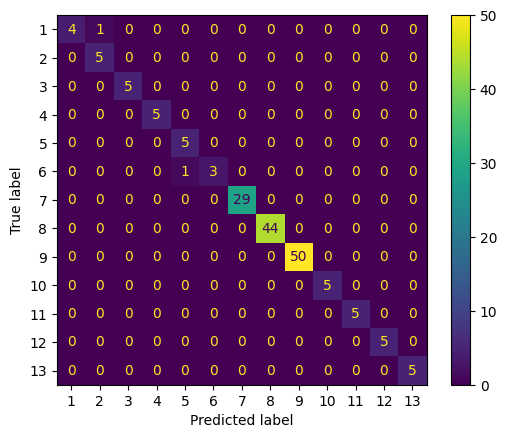

In [176]:
# Support Vector Classifier (SVC)
y_pred_svc = svc_model.predict(X_test)
print(classification_report(y_test, y_pred_svc))
ConfusionMatrixDisplay.from_estimator(svc_model, X_test, y_test)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.99      0.98      0.98       172
weighted avg       1.00      0.99      0.99       172



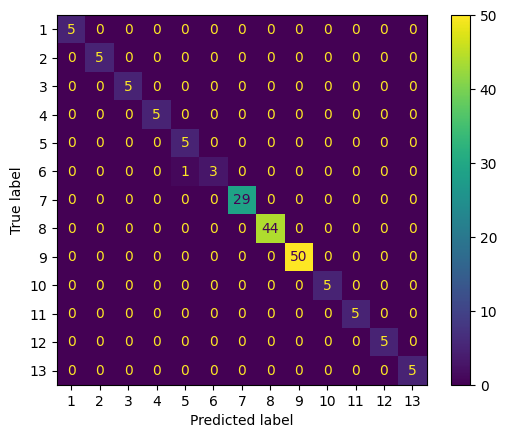

In [177]:
# Logistic Regression Classifier
y_pred_lrc = lrc_model.predict(X_test)
print(classification_report(y_test, y_pred_lrc))
ConfusionMatrixDisplay.from_estimator(lrc_model, X_test, y_test)

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.99      0.99      0.99       172



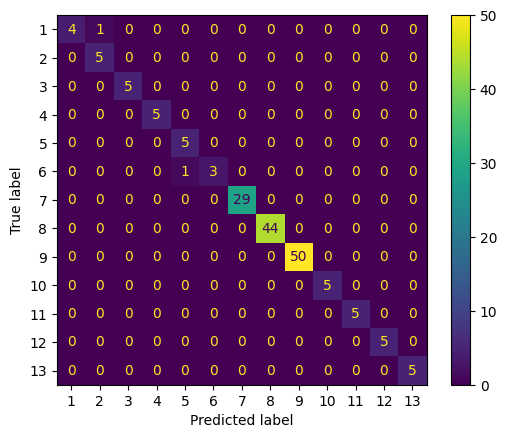

In [178]:
# Random Forest Classifier
y_pred_rfc = rfc_model.predict(X_test)
print(classification_report(y_test, y_pred_rfc))
ConfusionMatrixDisplay.from_estimator(rfc_model, X_test, y_test)

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.99      0.98      0.98       172
weighted avg       1.00      0.99      0.99       172



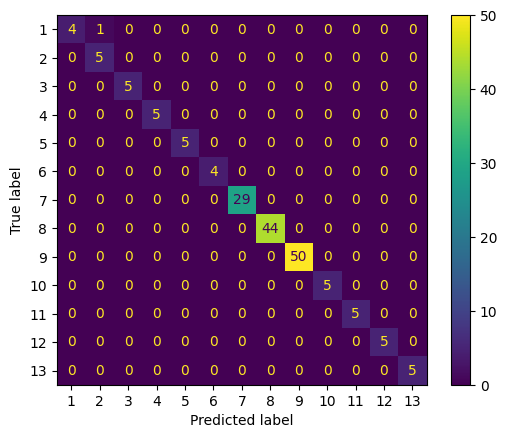

In [179]:
# Decision Tree Classifier
y_pred_dtc = dtc_model.predict(X_test)
print(classification_report(y_test, y_pred_dtc))
ConfusionMatrixDisplay.from_estimator(dtc_model, X_test, y_test)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.99      0.98      0.98       172
weighted avg       1.00      0.99      0.99       172



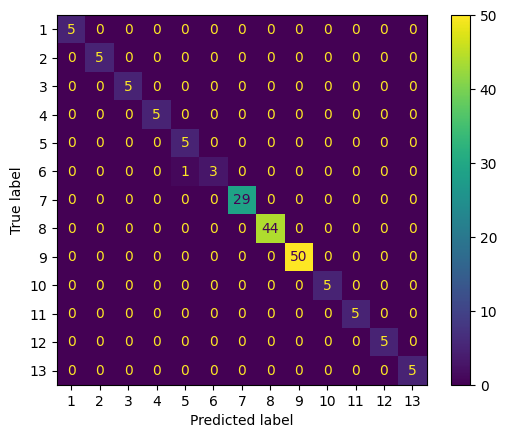

In [180]:
# K Neighbors Classifier - Randomized Search CV
y_pred_knc_rand = knc_rand_model.predict(X_test)
print(classification_report(y_test, y_pred_knc_rand))
ConfusionMatrixDisplay.from_estimator(knc_rand_model, X_test, y_test)

### Step 6: Stacked Model Performance Analysis - 5 Marks

Using scikit-learn’s StackingClassifier, combine two of the previously trained models to analyze the impact of model stacking on overall performance. Evaluate the performance of
the stacked model based on their f1 score, precision and accuracy along with a confusion
matrix to provide a clear visual representation. Include this confusion matrix in the report
for detailed performance analysis. If a significant increase in accuracy is observed, discuss
how combining complementary strengths of the models contributed to the improvement.
Conversely, if the change is minimal, explain why you think the stacking models had limited
effectiveness.

Package(s) required: scikit-learn

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                           0.99       172
   macro avg       0.99      0.98      0.98       172
weighted avg       1.00      0.99      0.99       172



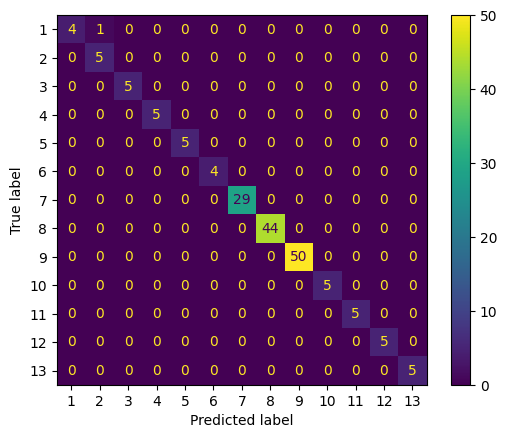

In [181]:
stack_model = StackingClassifier(
    estimators=[("knc", knc_rand_model), ("dtc", dtc_rand_model)],
    final_estimator=LogisticRegression()
)
stack_model.fit(X_train, y_train)

y_test_stack = stack_model.predict(X_test)
print(classification_report(y_test, y_test_stack))
ConfusionMatrixDisplay.from_estimator(stack_model, X_test, y_test)

### Step 7: Model Evaluation - 10 Marks

Package the selected model and save it in a joblib format, this allows you to call the model
to predict the class based on random set of coordinates given.

Package(s) required: Joblib

Based on the data set provided, you are required to predict the corresponding maintenance
step:

[9.375,3.0625,1.51], [6.995,5.125,0.3875], [0,3.0625,1.93], [9.4,3,1.8], [9.4,3,1.3]

In [182]:
# Save the model into the models directory
file_name = "stack_model.joblib"
directory = "models"
file_path = os.path.join(directory, file_name)
joblib.dump(stack_model, file_path)

['models/stack_model.joblib']

In [183]:
# Create a dataframe with the points to predict
steps = [
    [9.375, 3.0625, 1.51],
    [6.995, 5.125, 0.3875],
    [0, 3.0625, 1.93],
    [9.4, 3, 1.8],
    [9.4, 3, 1.3],
]
feature_names = df.columns[:-1]
step_df = pd.DataFrame(steps, columns=feature_names)
step_df_norm = pd.DataFrame(scaler.transform(step_df), columns=step_df.columns)

# Load the saved model
classification_model = joblib.load(file_path)
step_predictions = stack_model.predict(step_df_norm)
print(step_predictions)
# Display each of the point predictions
for i in range(step_predictions.size):
    print(f"For position {steps[i]}, the step is: {step_predictions[i]}")

[ 5  8 13  6  4]
For position [9.375, 3.0625, 1.51], the step is: 5
For position [6.995, 5.125, 0.3875], the step is: 8
For position [0, 3.0625, 1.93], the step is: 13
For position [9.4, 3, 1.8], the step is: 6
For position [9.4, 3, 1.3], the step is: 4


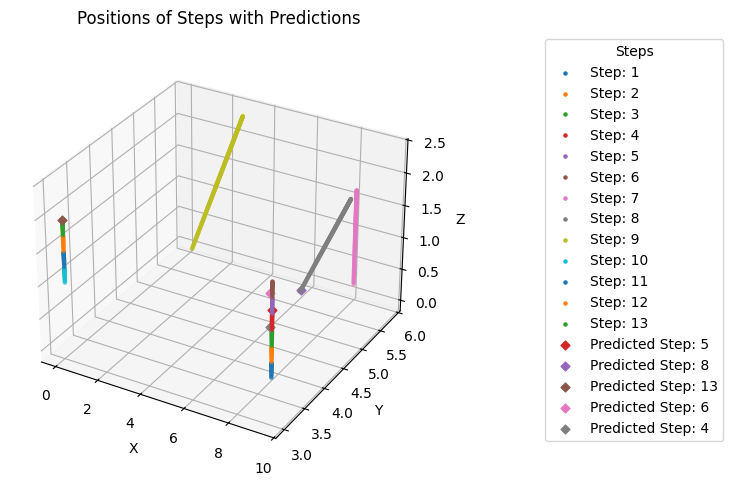

In [184]:
# Create a 3D plot of points with colour coding for each step
fig_2 = plt.figure()
fig_2.suptitle("Positions of Steps with Predictions")

# Create a 3d axis
ax = fig_2.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Get unique values in Step column (will be used for colour coding)
unique_vals = df["Step"].unique()

# Iterate over each unique value
for i, val in enumerate(unique_vals):
    temp_df = df[
        df["Step"] == val
    ]  # Create new df where Step is equal to current selected step
    ax.scatter(
        temp_df["X"], temp_df["Y"], temp_df["Z"], marker=".", label=f"Step: {val}"
    )

# Add predicted points
for i in range(step_predictions.size):
    ax.scatter(
        step_df["X"].iloc[i],
        step_df["Y"].iloc[i],
        step_df["Z"].iloc[i],
        marker="D",
        label=f"Predicted Step: {step_predictions[i]}",
    )

# Place legend outside of the plot
fig_2.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Steps")
plt.tight_layout()
plt.show()